In [25]:
import ufl
import matplotlib.pyplot as plt
import time
import numpy as np
from dolfin import *
import matplotlib.tri as tri
import warnings
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [26]:
# suppress FEniCS output to terminal
set_log_active(False)
# output directory
output_dir = ""

comm = MPI.comm_world  # MPI communications
rank = comm.Get_rank()  # number of current process
size = comm.Get_size()  # total number of processes

In [27]:
# mesh = Mesh()
# with XDMFFile(comm, "mesh/Mesh_3D.xdmf") as infile:
#     infile.read(mesh)
mesh_size = 25
# Create mesh
L = 500  # Length
W = 500  # Width
H = 125  # Height
# Define mesh
nx, ny, nz = int(L / mesh_size), int(W / mesh_size), int(H / mesh_size)
mesh = BoxMesh(Point(0, 0, 0), Point(L, W, H), nx, ny, nz)
nd = mesh.geometry().dim()  # mesh dimensions (2D or 3D)

In [28]:
# Step 4: Define the xdmf file for writing
xdmf = XDMFFile("Test3D.xdmf")
xdmf.parameters["flush_output"] = True
xdmf.parameters["rewrite_function_mesh"] = True
xdmf.parameters["functions_share_mesh"] = True

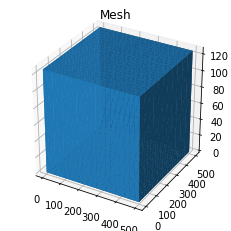

In [29]:
# Plot the mesh
plot(mesh,title='Mesh')
plt.show()

In [30]:
min_mesh_size = mesh.hmin()
print("Minimum mesh size:", min_mesh_size)

Minimum mesh size: 43.30127018922193


In [31]:
"""Material parameters."""

rho_ice = 917  # density of ice (kg/m^3)
rho_H2O = 1020  # density of seawater (kg/m^3)
grav = 9.81  # gravity acceleration (m/s**2)
temp = -10 + 273  # temperature (K)
B0 = 2.207e-3  # viscosity coefficient (kPa * yr**(1/3))
B0 *= 1e3  # convert to (Pa * yr**(1/3))
B0 *= (365*24)**(1/3)  # convert to (Pa * hour**(1/3))
BT = B0*np.exp(3155/temp - 0.16612/(273.39 - temp)**1.17)


In [32]:
"""Damage parameters."""

alpha = 0.21  # weight of max principal stress  in Hayhurst criterion
beta = 0.63  # weight of von Mises stress in Hayhurst criterion
r = 0.43  # damage exponent
B = 5.232e-7  # damage coefficient
k1, k2 = -2.63, 7.24  # damage rate dependency parameters
Dcr = 0.6  # critical damage
Dmax = 0.99  # maximum damage
lc = 10  # nonlocal length scale
# prec_ratio = 0.08
hs_ratio = 0 # water level in crevasse (normalized with crevasse height)
hw_ratio = 0 # water level at right terminus (normalized with glacier thickness)
prec_ratio = 0.08 # depth of pre-crack (

In [33]:
"""Set simulation time and timestepping options."""

t_total = 480  # total time (hours)
t_elapsed = 0  # current elapsed time (hours)
t_delay_dmg = 0  # delay damage (hours)
max_Delta_t = 2  # max time increment (For dmage set to 0.5 hours)
max_Delta_D = 0.1  # max damage increment
output_increment = 10  # number of steps between output
time_counter = 0  # current time step

In [34]:

"""Mesh details."""
# L, H = 500, 125  # domain dimensions
hs = 0  # water level in crevasse (normalized with crevasse height)
hw = 0  # water level at terminus (absolute height)
# mesh = load_mesh(output_dir + "mesh/hdf5/notch.h5")
# nd = mesh.geometry().dim()  # mesh dimensions (2D or 3D)

In [35]:
"""Define function spaces."""
S1 = FunctionSpace(mesh, "CG", 1)  # first order scalar space
S2 = FunctionSpace(mesh, "CG", 2)  # second order scalar space
V1 = VectorFunctionSpace(mesh, "CG", 1)  # first order vector space
V2 = VectorFunctionSpace(mesh, "CG", 2)  # second order vector space
P1 = FiniteElement("CG", mesh.ufl_cell(), 1)  # first order scalar element
P2 = VectorElement("CG", mesh.ufl_cell(), 2)  # second order vector element
V = FunctionSpace(mesh, MixedElement([P2, P1]))  # mixed finite element

In [36]:
"""Coordinates of nodes on initial mesh configuration."""
X1, X2, X3 = S1.tabulate_dof_coordinates().reshape((-1, nd)).T  # coordinates
n_local = len(X1)  # number of coordinates on local process
n_global = S1.dim()  # number of coordinates in global system

In [37]:
L,B,H= max(X1),max(X2), max(X3) 

In [38]:
L

500.0

In [39]:
B

500.0

In [40]:
H

125.0

In [41]:
def mwrite(filename, my_list):
    MPI.barrier(comm)
    if rank == 0:
        with open(filename, "w") as f:
            for item in my_list:
                f.write("%s" % item)


def mprint(*argv):
    if rank == 0:
        out = ""
        for arg in argv:
            out = out + str(arg)
        # this forces program to output when run in parallel
        print(out, flush=True)


In [42]:
mprint("Number of vertices      : {}".format(S1.dim()))
mprint("Number of cells         : {}".format(V1.dim()))
mprint("Number of DoF           : {}".format(V1.dim()))
mprint("Number of processes     : {}".format(size))
mprint("Number of DoF/process   : {}".format(int(V.dim() / size)))
mprint("-----------------------------------------------------")

Number of vertices      : 2646
Number of cells         : 7938
Number of DoF           : 7938
Number of processes     : 1
Number of DoF/process   : 58119
-----------------------------------------------------


In [43]:

"""Define function spaces."""
S1 = FunctionSpace(mesh, "CG", 1)  # first order scalar space
S2 = FunctionSpace(mesh, "CG", 2)  # second order scalar space
V1 = VectorFunctionSpace(mesh, "CG", 1)  # first order vector space
V2 = VectorFunctionSpace(mesh, "CG", 2)  # second order vector space
P1 = FiniteElement("CG", mesh.ufl_cell(), 1)  # first order scalar element
P2 = VectorElement("CG", mesh.ufl_cell(), 2)  # second order vector element
V = FunctionSpace(mesh, MixedElement([P2, P1]))  # mixed finite element

front = CompiledSubDomain("near(x[0], 0)")
back = CompiledSubDomain("near(x[0], L)",L=L)
left = CompiledSubDomain("near(x[1], 0)")
right_csd = CompiledSubDomain("near(x[1], B)", B=B)
bottom = CompiledSubDomain("near(x[2], 0)")
top = CompiledSubDomain("near(x[2], H)", H=H)

# Define the boundary conditions
bottom_roller = DirichletBC(V.sub(0).sub(2), Constant(0),bottom)  # Set v2 component to 0
left_roller = DirichletBC(V.sub(0).sub(1), Constant(0), left)   # Set v1 component to 0
front_roller = DirichletBC(V.sub(0).sub(0), Constant(0), front)          # Set v0 component to 0
back_roller = DirichletBC(V.sub(0).sub(0), Constant(0), back)            # Set v0 component to 0


# disp_bc = [bottom_roller, left_roller,front_roller,back_roller]

z_co_ord = Function(S1)
z_co_ord.interpolate(Expression("x[2]", degree=1))

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
left.mark(boundaries, 1)
right_csd.mark(boundaries, 2)
bottom.mark(boundaries, 3)
top.mark(boundaries, 4)
ds = Measure("ds", subdomain_data=boundaries)

BC = [bottom_roller, left_roller,front_roller,back_roller]

In [44]:
"""define functions that are required to solve the problem"""

def bodyforce(dmg, y):
    """Gravity loading as a body force. Fully failed points have
        no density unless they are filled with water. Then they
        have the same density as water.
    """
    Dcr = 0.6
    b = Function(V1)  # body force as vector function
    by = Function(S1)  # y-component of vector function
    for i in range(n_local):
        by.vector()[i] = -rho_ice*grav
    assign(b.sub(2), by)
    return b

# def hydrostatic(h):
#     h_expression = Expression(("(h - x[1] > 0 ?-rho_H2O * grav*(h - x[1]) : 0)",0), h=hw, rho_H2O=rho_H2O, grav=grav, degree=1)
#     return h_expression


# def hydrostatic(h, B):
#     h_expression = Expression(("(x[0] >= B && h - x[1] > 0 ? -rho_H2O * grav * (h - x[1]) : 0)", "0"), h=h, B=B, rho_H2O=rho_H2O, grav=grav, degree=1)
#     return h_expression


In [45]:
"""Define constitutive and kinematic relationships."""


def D(u):
    """Symmetric gradient operator."""
    return sym(nabla_grad(u))


# def DII(u):
#     """Second strain invariant."""
#     return (0.5*(D(u)[0, 0]**2 + D(u)[1, 1]**2) + D(u)[0, 1]**2)

def DII(u):
    """Second strain invariant."""
    return 0.5*inner(D(u),D(u))


def eta1(u, n=3, gam=1e-14):
    """Nonlinear viscosity."""
    return 0.5*BT*(DII(u) + gam)**((1 - n)/2/n)


def np_array(x):
    """converts x in to a vector format computed at the nodes"""
    return x.vector().get_local()


def mac(x):
    """Macaulay's bracket"""
    return (x+abs(x))/2


In [46]:
"""Initial guess for Picard iterations."""

uk = Function(V2)  # velocity
pk = Function(S1)  # pressure
dmg = Function(S1)
comm.Barrier()


In [ ]:

"""Main time loop."""
#t_total t_elapsed
while t_elapsed < t_total:

    time_counter += 1
    # get current configuration coordinates
    x1, x2, x3 = S1.tabulate_dof_coordinates().reshape((-1, nd)).T
    
    """Extract coordinates infor."""
    L,B, H= max(x1),max(x2), max(x3)  
    n_local = len(x1)  # number of coordinates on local process
    n_global = S1.dim()  # number of coordinates in global system


    u, p = TrialFunctions(V)  # trial functions in (V2, S1) space
    v, q = TestFunctions(V)  # test functions in (V2, S1) space


    # define loading terms
    b_grav = bodyforce(dmg=dmg, y=x3) # gravity for ice and water
#     b_hw = hydrostatic(h=hw)  # terminus pressure

  # incompressibility terms
    penalty = False
     
    ### update degradation function with damage value from previous step

    # define variational form
    LHS = (inner(D(v), 2*eta1(uk)*D(u)) - div(v)*p
           + q*div(u))*dx
    if penalty:
        LHS += 1e12*inner(nabla_div(u), psi*div(v))*dx  # penalty term
        
    RHS = inner(v, b_grav)*dx  # ice and water gravity
    
#     if hw > 0:
#         RHS += inner(v, b_hw)*ds(2)  # terminus pressure
        
    """ Picard iterations. """

    eps_local = 1  # local error norm
    eps_global = 1  # global error norm
    tol = 1e-4  # error tolerance
    picard_count = 0  # iteration count
    picard_max = 50  # maximum iterations
    w = Function(V)  # empty function to dump solution

    while (abs(eps_global) > tol) and (picard_count < picard_max):

        # solve the variational form
        solve(LHS == RHS, w, BC)
        u, p = w.split(deepcopy=True)
        u1, u2, u3 = u.split(deepcopy=True)

        # compute error norms
        u1k, u2k, u3k = uk.split(deepcopy=True)
        diff1 = u1.vector().get_local() - u1k.vector().get_local()
        diff2 = u2.vector().get_local() - u2k.vector().get_local()
        diff3 = u3.vector().get_local() - u3k.vector().get_local()
        diffp = p.vector().get_local() - pk.vector().get_local()
        eps1 = np.linalg.norm(diff1)/np.linalg.norm(u1.vector().get_local())
        eps2 = np.linalg.norm(diff2)/np.linalg.norm(u2.vector().get_local())
        eps3 = np.linalg.norm(diff3)/np.linalg.norm(u3.vector().get_local())
        epsp = np.linalg.norm(diffp)/np.linalg.norm(p.vector().get_local())

        # update solution for next iteration
        assign(uk, u)
        assign(pk, p)

        comm.Barrier()

        # obtain the max error on the local process
        eps_local = max(eps1, eps2,eps3, epsp)
        # obtain the max error on all processes
        eps_global = comm.allreduce(eps_local, op=MPI.max)


        # update iteration count
        picard_count += 1
        
    # build effective deviatoric stress tensor
    tau = 2*eta1(u)*D(u)
    t11 = project(tau[0, 0], S1).vector().get_local()
    t22 = project(tau[1, 1], S1).vector().get_local()
    t33 = project(tau[2, 2], S1).vector().get_local()
    t12 = project(tau[0, 1], S1).vector().get_local()

    dmg0 = dmg.vector().get_local()# damage from previous time step
    prs = interpolate(p, S1).vector().get_local()# effective pressure

    t23 = project(tau[1, 2], S1).vector().get_local()

    t13 = project(tau[0, 2], S1).vector().get_local()

 
    # effective Cauchy stress
    s11, s22, s33, s12, s23, s13 = t11 - prs, t22 - prs, t33 - prs, t12, t23, t13
    
#     I1 = s11 + s22 + s33  # effective I1 invariant
#     I1_true = I1 # true I1 invariant
#     I2 =s11*s22 + s22*s33 + s33*s11 - s12**2 - s23**2 - s13**2 #I3 invariant
#     I3 =

#     J2 = 0.5*(t11**2 + t22**2 + t33**2) + t12**2  # effective J2 invariant
#     vms = np.sqrt(3*J2)  # effective von Mises stress

#     lam1 = s33
#     lam2 = 0.5*(s11 + s22 + np.sqrt(s11**2 - 2*s11*s22 + 4*(s12**2) + s22**2))
#     mps = np.fmax(lam1, lam2)  # effective max principal stress

#     # effective Hayhurst stress
#     chi = alpha*mps + beta*vms + (1 - alpha - beta)*I1

    """ Output data to mesh file. """

    Delta_t = max_Delta_t # time step = 0.5 hours ( for only Stoke, can set time step to any number)
    """ Save data """
    
    N11 = Function(S1, name="S11") # Normal stress
#     H11 = Function(S1, name="H11") # Hayhurst stress
#     V11 = Function(S1, name="V11") # von Mises stress
#     P11 = Function(S1, name="P11") # max principal stress
    
    # Assuming s11, chi, and vms are NumPy arrays or similar
    N11.vector()[:] = s11
#     H11.vector()[:] = chi
#     V11.vector()[:] = vms
#     P11.vector()[:] = mps

#     Write the data
    xdmf.write(N11, t_elapsed)
#     xdmf.write(V11, t_elapsed)
#     xdmf.write(H11, t_elapsed)
#     xdmf.write(P11, t_elapsed)
    
    """ Updated Lagrangian implementation. """

    # split velocity into components in S1 space
    u1, u2, u3 = u.split(deepcopy=True)
    u1 = interpolate(u1, S1).vector().get_local()
    u2 = interpolate(u2, S1).vector().get_local()
    u3 = interpolate(u3, S1).vector().get_local()

    # compute the displacement increment vector Delta_u
    Delta_u1 = Function(S1)
    Delta_u2 = Function(S1)
    Delta_u3 = Function(S1)

    Delta_u1.vector()[:] = u1*Delta_t
    Delta_u2.vector()[:] = u2*Delta_t
    Delta_u3.vector()[:] = u3*Delta_t


    Delta_u = Function(V1)
    assign(Delta_u.sub(0), Delta_u1)
    assign(Delta_u.sub(1), Delta_u2)
    assign(Delta_u.sub(2), Delta_u3)

    
    # move the mesh, update coordinates
    ALE.move(mesh, Delta_u)

    # update elapsed time
    t_elapsed += Delta_t

    print("Time: %0.2f" % (t_elapsed))


Time: 2.00
Time: 4.00
Time: 6.00
Time: 8.00
Time: 10.00
Time: 12.00


In [ ]:
# Test for PETSc or Tpetra
if not has_linear_algebra_backend("PETSc") and not has_linear_algebra_backend("Tpetra"):
    info("DOLFIN has not been configured with Trilinos or PETSc. Exiting.")
    exit()

if not has_krylov_solver_preconditioner("amg"):
    info("Sorry, this demo is only available when DOLFIN is compiled with AMG "
         "preconditioner, Hypre or ML.")
    exit()

if has_krylov_solver_method("minres"):
    krylov_method = "minres"
elif has_krylov_solver_method("tfqmr"):
    krylov_method = "tfqmr"
else:
    info("Default linear algebra backend was not compiled with MINRES or TFQMR "
         "Krylov subspace method. Terminating.")
    exit()